Delete all variables in the current environment (if you have already run some cells) - clean state.

In [71]:
%reset

Import all necessary packages.

In [72]:
import os
import shutil
import json
from dateutil import parser
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import textwrap

Replace with the path to the root folder of the project.

In [73]:
rootdir_path = '/home/andreistoica12/research-internship'

Replace with the path to the folder where we store the dataset.

In [74]:
data_path = '/home/andreistoica12/research-internship/data/PhemeDataset'

IMPORTANT NOTE: After running the code, some files from the dataset will be different from the original versions, i.e. the "retweets.json" files inside each story folder were initially invalid. In order to consider and process the retweets in the longitudinal analysis, I formatted these files so that they are valid, parsable JSON files. If the file contained only one retweet object, it has not been modified. If the file contained multiple retweets, the file now contains a list of retweet objects, separated by a comma, as per the JSON syntax.

The paths to the folder containing all subfolders corresponding to each event of major interest (the Charlie Hebdo shooting, footballer Essien having Ebola, etc.). Tweets here are all written in English.

In [75]:
events_path = data_path + "/threads/en"

Code snippets that create 2 folders, along with respective subfolders, within the root folder of the project.
Those folders will store locally graphs obtained through running the code, as well as important auxiliary files.
If they already existed (from previous runnings of the project), I delete the tree strarting from those folders 
(all subfolders and contents) and create empty folders and subfolders, relevant for the current state of the project.

In [76]:
def build_subfolders(root_folder, subfolders_tree):
    for key, value in subfolders_tree.items():
        globals()[key] = os.path.join(root_folder, value)
        if os.path.exists(globals()[key]):
            shutil.rmtree(globals()[key], ignore_errors=False, onerror=None)
        os.makedirs(globals()[key])

In [77]:
rootdir_subfolders_tree = {
    'files_path': 'files',
    'graphs_path': 'graphs'
}

In [78]:
build_subfolders(rootdir_path, rootdir_subfolders_tree)

In [79]:
graphs_subfolders_tree = {
    'pheme_graphs_path': 'pheme'
}

In [80]:
build_subfolders(globals()['graphs_path'], graphs_subfolders_tree)

In [81]:
pheme_graphs_subfolders_tree = {
    'pheme_time_distributions_graphs': 'time-distributions',
    'pheme_reaction_times_graphs': 'reaction-times',
    'pheme_reaction_counts_graphs': 'reaction-counts',
    'pheme_avg_reaction_counts_graphs': 'avg-reaction-counts',
    'pheme_influencers_source_graphs': 'influencers-source',
    'pheme_influencers_all_graphs': 'influencers-all',
    'pheme_avg_followers_counts_source_graphs': 'avg-followers-counts-source',
    'pheme_avg_followers_counts_all_graphs': 'avg-followers-counts-all',
    'pheme_following_graphs': 'following',
    'pheme_avg_following_graphs': 'avg-following',
    'pheme_following_percentages_graphs': 'following-percentages'
}

In [82]:
build_subfolders(globals()['pheme_graphs_path'], pheme_graphs_subfolders_tree)

Here, I define a function that first reads the JSON file and stores it into a dictionary, then parses the date contained at the "created_at" key. The number returned is an integer. 

In [83]:
def tweet_hour(tweet_path):
    """Function that parses a JSON file associated with a tweet in the PhemeDataset and returns the posting hour.

    Args:
        tweet_path (str): path to the JSON file associated with a tweet

    Returns:
        int: posting hour of a tweet
    """    
    with open(tweet_path) as f:
        tweet = json.load(f)
    date = parser.parse(tweet['created_at'])
    
    return date.hour

Function to return the source path, given the story path.

In [84]:
def source_tweet_path(story_path):
    """Function that, given the path to a story, gets the path to the JSON file corresponding to the source tweet.

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        str: path to the source tweet JSON file
    """    
    source_dir_path = story_path + "/source-tweets"
    source_path = source_dir_path + "/" + os.listdir(source_dir_path)[0]
    
    return source_path

Function to return a list of all reactions' paths.

In [85]:
def reaction_tweets_paths(story_path):
    """Function that generates a list of reactions (replies) to a tweet within a story.

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        list: list of paths(strings) for the reactions to the source tweet of a story
    """    
    reactions_paths_list = []
    reactions_dir_path = story_path + "/reactions"
    for reaction_name in os.listdir(reactions_dir_path):
        reaction_path = reactions_dir_path + "/" + reaction_name
        reactions_paths_list.append(reaction_path)
        
    return reactions_paths_list

Function to validate whether a given JSON file is valid or not. Unmodified retweets files (the ones from the original dataset) are not valid. We only want ot modify them when they are invalid, otherwise they will become invalid again, as we will have duplicate characters ("[[" / "]]" / ",,") .

In [86]:
def validateJSON(JSON_path):
    """Function that checks whether a JSON file is valid or invalid.

    Args:
        JSON_path (str): path to a JSON file

    Returns:
        bool: True for a valid JSON file, False otherwise
    """    
    try:
        with open(JSON_path, 'r') as file:
            data = json.load(file)
    except ValueError as err:
        return False
    return True

Function to modify/format invalid JSON files for further processing.

In [87]:
def format_retweets_json(retweets_path):
    """Function that transforms an invalid JSON file which contains multiple objects, not correctly separated through a comma and
    not having square brackets at the beginning and end of the file, into a valid JSON file.

    Args:
        retweets_path (str): path to the invalid JSON file
    """    
    if not validateJSON(retweets_path):
        with open(retweets_path, 'r') as invalid_json:
            data = invalid_json.read()
        data = "[\n" + data.replace("}\n{", "},\n{") + "]"
        with open(retweets_path,'w') as valid_json:
            valid_json.write(data)

Function to return a list of the hours when all retweets of a specific story have been posted.

In [88]:
def hours_list_retweets(story_path):
    """Function that generates a list of the posting hours of all retweets.

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        list: list of the posting hours for all retweet occurences.
    """    
    retweets_path = story_path + "/retweets.json"
    hours = []
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            hours = [ parser.parse(retweet['created_at']).hour for retweet in retweets_list ]
        else:   # we have this case when the JSON file contains one object, but we need to pass a list forward, so we'll have a 1-length list
            hours = [parser.parse(retweets_list['created_at']).hour]

    return hours

I define a function to store all occurences of dates (only the hours) in a list.

In [89]:
def hours_list_story(story_path):
    """Function that generates a list of the posting hours of all tweets (source tweet, replies, retweets) within a story.

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        list: list of the posting hours for all tweets (source tweet, replies, retweets) within a story.
    """    
    # I create a list with all occurences of dates corresponding to the source tweet, reactions (replies) and retweets.
    hours = []

    # source hour
    source_path = source_tweet_path(story_path)
    hour = tweet_hour(source_path)
    hours.append(hour)

    # reactions hours
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        hour = tweet_hour(reaction_path)
        hours.append(hour)
    
    # retweets hours
    hours.extend(hours_list_retweets(story_path))
    
    return hours

Here, I define a function to return a pandas Series, representing the distribution of the hours of tweets (source tweets, reactions and retweets) posted regarding a specific event given as an input parameter. I chose to convert the list to a pandas Series due to the ease in creating a distribution and corresponding box plot.

In [90]:
def time_distribution_event(event_path):
    """Function that creates a distribution of the posting hours of the tweets (source tweets, replies, retweets) related to an event.

    Args:
        event_path (str): path to the root folder of a event (e.g. /your/path/to/charliehebdo)

    Returns:
        pandas.core.series.Series: distribution of the posting hours of all tweets related to an event
    """    
    hours = []
    for story_id in os.listdir(event_path):
        story_path = event_path + "/" + story_id
        hours.extend(hours_list_story(story_path))
    hours.sort()
    hours_series = pd.Series(hours)
    distribution = hours_series.value_counts()[hours_series.unique()]
    
    return distribution

The following function is delegated to plot the distribution per hour of the tweets sent about a specific topic/event.

In [91]:
def plot_time_distribution_event(event_name, distribution):
    """Function that saves the bar chart plot with the distribution of the posting hours of all tweets related to an event, locally.

    Args:
        event_name (str): name of an event (e.g. charliehebdo)
        distribution (pandas.core.series.Series): distribution of the posting hours of all tweets related to an event
    """    
    axes = distribution.plot(kind='bar')
    figure_path = f"{globals()['pheme_time_distributions_graphs']}/{event_name}_distribution.png"
    axes.figure.savefig(figure_path)
    plt.close()

Function to plot and save in the local graphs/ folder the distributions corresponding to all events.

In [92]:
def plot_time_distributions(events_path):
    """Function that saves a bar chart plot with the distribution of the posting hours of all tweets related to each event, locally.

    Args:
        events_path (str): path to the root folder of the events (e.g. /your/path/to/threads/en)
    """    
    for event_name in os.listdir(events_path):
        event_path = events_path + "/" + event_name
        distribution = time_distribution_event(event_path)
        plot_time_distribution_event(event_name, distribution)

In [93]:
plot_time_distributions(events_path)

Computing the reaction times to tweets

In [94]:
deltas_types = ['hours', 'minutes']

Choose between 'hours' and 'minutes' if you want to plot the final graph in hours or minutes.

NOTE: This variable needs to have either one of the values in the deltas_types list, otherwise the deltas will be an empty list,
so the plots will make no sense in the end.

In [95]:
deltas_type = deltas_types[0]

In [96]:
def deltas_story(story_path, deltas_type):
    """Function that generates a list of time differences between the moment a reaction (reply or retweet) has been posted
    and the moment the source tweet of a story has been posted. Depending on the time unit of such time difference 
    (e.g. 'hours' or 'minutes'), the function outputs a list with numbers expressed in the respective type.

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)
        deltas_type (str): time unit for time differences

    Returns:
        list: list of time differences expressed in deltas_type time units
    """    
    if deltas_type not in ['minutes', 'hours']:
        print("Deltas type doesn't have a valid value - it should be either 'hours' or 'minutes' !")
        return []
    
    factor = 60 * 60
    factor = 60 if deltas_type == 'minutes' else factor

    deltas = []

    # Step 1: get t0 datetime object from the source timestamp
    source_path = source_tweet_path(story_path)
    with open(source_path) as file:
        source = json.load(file)
    t0 = parser.parse(source['created_at'])

    # Step 2: for all reactions, get the difference in minutes/hours 
    # from the time the source was posted and the time each reaction was posted
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        with open(reaction_path) as file:
            reaction = json.load(file)
        deltas.append((parser.parse(reaction['created_at']) - t0).total_seconds() / factor )

    # Step 3: for all retweets, get the same time difference in miuntes as above
    retweets_path = story_path + "/retweets.json"
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            deltas.extend([ (parser.parse(retweet['created_at']) - t0).total_seconds() / factor for retweet in retweets_list ])
        else:   # here, the JSON file contains one object, but we need to pass a list forward, so we'll have a 1-length list
            deltas.extend([ (parser.parse(retweets_list['created_at']) - t0).total_seconds() / factor ])

    return deltas

In [97]:
def deltas_event(event_path, deltas_type):
    """Function that generates a list of time differences between the source tweets of all stories of an event
    and their respective reactions (replies and retweets).

    Args:
        event_path (str): path to the root folder of an event (e.g. /your/path/to/charliehebdo)
        deltas_type (str): time unit for time differences (e.g. 'hours', 'minutes')

    Returns:
        list: list of time differences expressed in the time unit specified as an input parameter (deltas_type)
    """
    deltas = []
    for story_name in os.listdir(event_path):
            story_path = event_path + "/" + story_name
            deltas.extend(deltas_story(story_path, deltas_type))

    return deltas

In [98]:
def deltas_all_events(events_path, deltas_type):
    """Function that generates a dictionary containing all time differences between the source tweets and their respective reactions
    (replies and retweets) for all events.

    Args:
        events_path (str): path to the root folder of the events (e.g. /your/path/to/threads/en)
        deltas_type (str): time unit for time differences (e.g. 'hours', 'minutes')

    Returns:
        dict: dictionary where keys are the event names and the values are lists of time differences
              expressed in the time unit specified as an input parameter (deltas_type)
    """    
    deltas_all_events = {}
    for event_name in os.listdir(events_path):
        event_path = events_path + "/" + event_name
        deltas_all_events[event_name] = deltas_event(event_path, deltas_type)
    
    return deltas_all_events

We need to define the number of clusters we want to have, as it needs to be passed onto the K-Means algorithm. Therefore, one of the easiest methods is to look for the "elbow" point in the plot above, i.e. the point where the rate of decrease in WCSS begins to level off. The optimal number of clusters can be found through the KneeLocator function within the kneed Python module. Curves with positive concavity are called "elbows", the ones with negative concavity are called "knees". Our K-Means inertia values are decreasing when we increase the number of clusters, because the inertia is calculated by measuring the distance between each data point and its centroid, so having more clusters means points will be closer to their clusters' centroids. So we will have a decreasing convex curve and thus we will pass on this information as arguments in the KneeLocator function.

In [99]:
def elbow_method_k_means_clusters(deltas, max_nr_clusters):
    """Function that calculates the optimal number of clusters that the K-Means clustering algorithm should create out of a list
    of one-dimensional elements. The function implements the Elbow Method of choosing the optimal number of clusters, meaning it fits 
    multiple K-Means models with different numbers of clusters (from 1 to max_nr_clusters) and compute the within-cluster sum of squares
    (wcss) for each model. The next step is to plot the wcss values against the number of clusters and look for the "elbow" point,
    where the rate of decrease in wcss begins to level off. This is a good indication of the optimal number of clusters. This step is
    performed with the help of the KneeLocator function within the kneed module.

    Args:
        deltas (list): one-dimensionaal list (e.g. time differences between the posting hour of a source tweet
                       and the posting hours of the reactions - replies and retweets)
        max_nr_clusters (int): maximum number of clusters that we take into account as potential optimal number to be returned

    Returns:
        int: optimal number of clusters for a K-Means clusterization
    """    
    wcss = []   # within-cluster sum of squares
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)
    for k in range(1, max_nr_clusters+1):
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
        kmeans.fit(deltas)
        wcss.append(kmeans.inertia_)

    kn = KneeLocator(range(1, max_nr_clusters+1), wcss, curve='convex', direction='decreasing')

    # # Plot the within-cluster sum of squares against the number of clusters
    # # If you want to visualize the knee point of the graph, you can plot the graph using the following function, 
    # # specifically designed to highlight the knee point
    # kn.plot_knee()

    return kn.knee

In [100]:
def k_means_clustering(k, deltas):
    """Function to generate the clusters after performing the K-Means clustering algoithm to a one-dimensional array.

    Args:
        k (int): number of clusters
        deltas (list): one-dimensional list (e.g. of time differences between the posting hour of a source tweet
                       and the posting hours of the reactions - replies and retweets)

    Returns:
        dict: dictionary with keys as auto-generated labels of the clusters and values as lists of elements in each cluster
    """    
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(deltas)

    # Get the labels assigned to each data point
    labels = kmeans.labels_

    # Get the centroids of each cluster
    centroids = kmeans.cluster_centers_

    # # Print an overview of the resulting clusters
    # for i in range(k):
    #     cluster_data = deltas[labels == i]
    #     print(f"Cluster {i+1} has {len(cluster_data)} data points and a centroid of {centroids[i][0]}")

    # Create a dictionary to store the clustered data
    clusters_dict = {}
    labels_list = []
    for label in labels:
        labels_list.append(label)
    
    for index, label in enumerate(labels_list):
        if label not in clusters_dict:
            clusters_dict[label] = [deltas[index][0]]
        else:
            clusters_dict[label].append(deltas[index][0])
    
    return clusters_dict

The implementation below makes use of the Nearest Neighbors algorithm in order to find the optimal value for epsilon, as per:
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc .
However, the distances plot seems odd and the knee obtained through the KneeLocator function doesn't yield the best results. For now, I set the eps parameter to be 0.3 so that we have good clustering results.

For example, I tried to cluster the deltas from all the stories within the Germanwings crash event.

In [101]:
deltas = deltas_event('/home/andreistoica12/research-internship/data/PhemeDataset/threads/en/prince-toronto', deltas_type)

In [102]:
len(deltas)

215

In [103]:
def epsilon_DBSCAN(deltas):
    """Function to compute the optimal value of the epsilon parameter - the most important input parameter - of the 
    DBSCAN clustering algorithm. The function first computes the distances between each point and its n-th (in our case, 5th)
    nearest neighbor and chooses the optimal value for the distance using the Elbow Method (it creates a graph of the distances
    against each data point and chooses the point where the curve starts to rise steeply).

    Args:
        deltas (list): one-dimensional list (e.g. of time differences between the posting hour of a source tweet
                       and the posting hours of the reactions - replies and retweets)

    Returns:
        float: optimal epsilon value for DBSCAN
    """    
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    neigh = NearestNeighbors(n_neighbors=5) # usually, the kth nearest neighbor is chosen somewhere between 3 and 10
    nbrs = neigh.fit(deltas)
    distances, indices = nbrs.kneighbors(deltas)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

    kn = KneeLocator(range(1, len(distances)+1), distances, curve='convex', direction='increasing')

    return float(distances[kn.knee])

As you can see, the graph seems odd.

0.13027777777777816

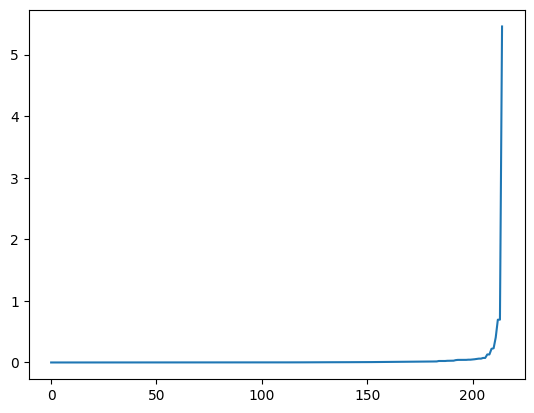

In [104]:
epsilon_DBSCAN(deltas)

In [105]:
def DBSCAN_clustering(deltas):
    """Function to cluster a list of one-dimensional elements with the help of the DBSCAN clustering algorithm.

    Args:
        deltas (list): list of one-dimensional elements (e.g. of time differences between the posting hour of a source tweet
                       and the posting hours of the reactions - replies and retweets)

    Returns:
        dict: dictionary with keys as auto-generated labels of the clusters and values as lists of elements in each cluster
    """    
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    # # Compute the value for epsilon using the function defined previously
    # epsilon = epsilon_DBSCAN(deltas)
    epsilon = 0.3

    # Create a DBSCAN object with epsilon as the computed value and minimum samples=5
    dbscan = DBSCAN(eps=epsilon, min_samples=5)

    # Fit the DBSCAN object to the data
    dbscan.fit(deltas)

    # Get the labels assigned to each data point
    labels = dbscan.labels_

    # # Print the number of clusters and the labels assigned to each data point
    # n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # print("Number of clusters:", n_clusters)
    # print("Labels:", labels)

    # Create a dictionary to store the clusters
    clusters_dict = {}
    for i, label in enumerate(labels):
        if label in clusters_dict:
            clusters_dict[label].append(deltas[i][0])
        else:
            clusters_dict[label] = [deltas[i][0]]
    
    return clusters_dict

Until now, I have implemented 2 ways to cluster the deltas. By default, I use the Density-Based Spatial Clustering of Applications with Noise (DBSCAN), because it focuses on the patterns that we observe from the majority of data points, and the outliers don't affect the way it clusters the other points, whereas the K-Means algorithm builds its centroids based on all the data points and it may be deceiving in a plot. Moreover, plots obtained with the DBSCAN clustering algorithm tend to yield more and tighter clusters than the number of clusters obtained with the help of the Elbow Method in the case of the K-Means clustering.

In [106]:
clustering_algorithms = ['k-means', 'DBSCAN']

In [107]:
clustering_algorithm = clustering_algorithms[1]

In [108]:
def clusters_all_events(events_path, deltas_type, clustering_algorithm):
    """Function that generates clusters for all events, using the clustering algorithm and the time unit
    for differences between the posting times of source tweets and their respective reactions' (replies and retweets) posting times,
    both given as input parameters.

    Args:
        events_path (str): path to the root folder of the events (e.g. /your/path/to/threads/en)
        deltas_type (str): time unit for time differences (e.g. 'hours', 'minutes')
        clustering_algorithm (str): clustering algorithm used (e.g. 'k-means', 'DBSCAN')

    Returns:
        dict: dictionary with keys as event names and values as dictionaries with clusters for each event
    """    
    all_events_deltas = deltas_all_events(events_path, deltas_type)
    all_events_clusters = {}
    for event_name, event_deltas in all_events_deltas.items():
        if clustering_algorithm == 'k-means':
            # loop over maximum 10 clusters, as this is a range where you usually find the optimum number of clusters
            k = elbow_method_k_means_clusters(event_deltas, 10)
            # print(f"\nEvent {event_name}:")
            # print(f"NOTE: Numbers represent {deltas_type}\n")
            all_events_clusters[event_name] = k_means_clustering(k, event_deltas)
        elif clustering_algorithm == 'DBSCAN':
            all_events_clusters[event_name] = DBSCAN_clustering(event_deltas)
        
    return all_events_clusters


Function that receives the first clusters generated either through K-Means or DBSCAN and tries to see whether it can find some subgraphs more relevant for the visualization. A recursive function is defined in order to re-cluster the biggest cluster until the newly-computed biggest cluster contains fewer than 70% of the data points. I considered this a good threshold to stop, because the graph will clearly show, on one hand, which is the overwhelingly biggest cluster, and on the other hand, the next number_of_clusters - 1 biggest clusters/subclusters so we have a better overview of the most important clusters/subclusters in our datasets. I chose to apply K-Means for the reapplication of clustering on the biggest cluster due to its computationally-efficient nature, which is hands-down superior to DBSCAN's. In fact, not only did the algorithm implemented with DBSCAN for subclusters take a lot longer, it even crashed before the end, due to the number of recursive calls exceeding the limit of the kernel. Therefore, considering the trade-off between better clustering and efficiency, the option below yielded the optimal results.

Besides technical reasons, I opted to first cluster the points with DBSCAN, due to its ability to ignore outlier points, they are not taken into account when clusters are created, which is of great help for a good visualization. After the first clusterization, we only have relevant points, so K-Means will yield good results (its problem were outlier points which influenced the computation of centroids).

In [109]:
def clusters_for_plot(clusters, number_of_clusters):
    """Function that creates the most populated number_of_clusters (or less, if after completion, the number os clusters is smaller)
    clusters or subclusters obtained after repeated clusterization. More specifically, the original list of data points is clustered
    with either DBSCAN or K-Means. Then, we analyze the most populated cluster. If it contains more than 70% of all data points,
    the function performs another clusterization on the biggest cluster. This operation is repeated until the most populated
    cluster or subcluster gather no more than 70% of the data points.

    Args:
        clusters (dict): clusters of the original data points, obtained through either DBSCAN or K-Means
        number_of_clusters (int): number of the biggest clusters or subclusters we want to save

    Returns:
        dict: dictionary with keys as integers ranging from 0 to number_of_clusters and values as the biggest number_of_clusters clusters,
              starting with the biggest and decreasing
    """    
    total_length = 0
    for value in clusters.values():
            total_length += len(value)
    subclusters_for_plot = {}
    
    def subclusters(clusters):
            if(len(clusters)):
                key_for_biggest_cluster = max(clusters, key=lambda k: len(clusters[k]))
                if len(clusters[key_for_biggest_cluster]) / total_length < 0.7:
                    print("Reached base case.")
                    return clusters
                else:
                    # print("We'll go back into subclusters function.")
                    # print(f"Length of current clusters: {len(clusters)}")
                    # print("Current clusters look like this:")
                    # for key, value in clusters.items():
                    #      print(f"{key}: {math.floor(min(value))} - {math.ceil(max(value))}")

                    biggest_cluster = clusters[key_for_biggest_cluster]
                    # print("Biggest cluster:")
                    # print(biggest_cluster[:3])
                    
                    del clusters[key_for_biggest_cluster]
                    # print("Clusters after removing biggest_cluster:")
                    # for key, value in clusters.items():
                    #      print(f"{key}: {math.floor(min(value))} - {math.ceil(max(value))}")
                    
                    # K-MEANS CLUSTERING
                    k = elbow_method_k_means_clusters(biggest_cluster, 10)
                    # print(f"k = {k}")
                    
                    subcl = k_means_clustering(k, biggest_cluster)
                    # print("subcl - the subclusters dictionary obtained from the biggest_cluster looks like this:")
                    # for key, value in subcl.items():
                    #      print(f"{key}: {math.floor(min(value))} - {math.ceil(max(value))}")
                    
                    for key, value in subcl.items():
                        clusters[max(clusters.keys())+1] = value
                    
                    # print(f"Length of clusters after modifications: {len(clusters)}")
                    # print("Clusters look like this:")
                    # for key, value in clusters.items():
                    #      print(f"{key}: {math.floor(min(value))} - {math.ceil(max(value))}")
                    
                    subclusters(clusters)
            else:
                print("Clusters dictionary is empty.")
                return clusters
            

    subclusters(clusters)

    if len(clusters) >= number_of_clusters:
        for i in range(number_of_clusters):
            key_for_biggest_cluster = max(clusters, key=lambda k: len(clusters[k]))
            subclusters_for_plot[i] = clusters[key_for_biggest_cluster]
            del clusters[key_for_biggest_cluster]
    else:
        subclusters_for_plot = clusters
    
    return subclusters_for_plot

In [110]:
def plot_reaction_times(events_path, deltas_type):
    """Function that saves a plot of the most populated clusters or subclusters for each event, locally, with labels in increasing order,
    based on the posting hour of the earliest tweet in the cluster.

    Args:
        events_path (str): path to the root folder of the events (e.g. /your/path/to/threads/en)
        deltas_type (str): time unit for time differences (e.g. 'hours', 'minutes')
    """    
    all_clusters = clusters_all_events(events_path, deltas_type, clustering_algorithm)

    for event_name, clusters in all_clusters.items():
        print(f"Event: {event_name}")
        clusters_to_be_plotted = clusters_for_plot(clusters, 5)

        final_clusters_for_plot = {}
        for key, value in clusters_to_be_plotted.items():
            final_clusters_for_plot[f"{math.floor(min(value))} - {math.ceil(max(value))}"] = len(value)

        intervals_unsorted = list(final_clusters_for_plot.keys())
        values_unsorted = list(final_clusters_for_plot.values())
        df_plot = pd.DataFrame(
            dict(
                Interval=intervals_unsorted,
                Value=values_unsorted
            )
        )
        
        df_plot['Start of interval'] = df_plot['Interval'].str.split(' - ').str[0]
        df_plot['Start of interval'] = df_plot['Start of interval'].apply(pd.to_numeric) 
        df_plot_sorted = df_plot.sort_values('Start of interval')
        intervals = list(df_plot_sorted['Interval'])
        values = list(df_plot_sorted['Value'])


        plt.bar(range(len(final_clusters_for_plot)), values, tick_label=intervals)
        # Rotate the x-axis labels by 45 degrees
        plt.xticks(rotation=45)
        plt.title(f'Distribution of reaction times in {deltas_type}')
        plt.xlabel(f'Reaction times (between x and y {deltas_type})')
        plt.ylabel('Number of reactions')
        plt.savefig(globals()['pheme_reaction_times_graphs'] + f"/{event_name}_reaction_times.png")
        plt.close()

NOTE: the cell below runs for ~22 sec on my machine if the session has just started. If you run the code again, it takes ~18 sec, due to probably cached information.

In [111]:
plot_reaction_times(events_path, deltas_type)

Event: germanwings-crash
Reached base case.
Event: ottawashooting
Reached base case.
Event: ferguson
Reached base case.
Event: sydneysiege
Reached base case.
Event: charliehebdo
Reached base case.
Event: prince-toronto
Reached base case.
Event: ebola-essien
Reached base case.
Event: putinmissing
Reached base case.


Reactions counts for the source tweets - the number of reactions per tweet posted at hour x.

In [112]:
def tweet_followers_count(tweet_path):
    """Function that gets the followers count of the author of a tweet

    Args:
        tweet_path (str): path to a JSON file associated with a tweet 
        (e.g. /your/path/to/charliehebdo/552783667052167168/source-tweets/552783667052167168)

    Returns:
        int: followers count of the user who posted the tweet
    """    
    with open(tweet_path) as f:
        tweet = json.load(f)
    
    return tweet['user']['followers_count']

In [113]:
def tweet_following(tweet_path):
    """Function that returns the value of the 'following' field of the 'user' in the JSON file associated with a tweet.

    Args:
        tweet_path (str): path to a JSON file associated with a tweet 
        (e.g. /your/path/to/charliehebdo/552783667052167168/reactions/552785374507175936.json)

    Returns:
        bool: true or false
    """    
    with open(tweet_path) as f:
        tweet = json.load(f)
    
    return tweet['user']['following']

In [114]:
def tweet_user_id(tweet_path):
    """Function that returns the value of the 'id' field of the 'user' in the JSON file associated with a tweet.

    Args:
        tweet_path (str): path to a JSON file associated with a tweet 
        (e.g. /your/path/to/charliehebdo/552783667052167168/reactions/552785374507175936.json)

    Returns:
        int: id of the user
    """    
    with open(tweet_path) as f:
        tweet = json.load(f)
    
    return tweet['user']['id']

In [115]:
def reactions_count_followers_count_for_source_tweet(story_path):
    """Function that generates the number of reactions (replies or retweets), as well as the number of followers of the author 
    for a single source tweet (a story contains one source tweet).

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        int: number of reactions for a source tweet, 
        int: followers counts of the user who posted the source tweet
    """  
    source_path = source_tweet_path(story_path)
    followers_count = tweet_followers_count(source_path)
    
    reactions_paths_list = reaction_tweets_paths(story_path)
    reactions_count = len(reactions_paths_list)

    retweets_path = story_path + "/retweets.json"
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        reactions_count += len(retweets_list)

    return reactions_count, followers_count

In [116]:
def followers_list_for_user(user_id, who_follows_whom_path):
    """Function that generates the list of followers for a specified user, out of the users who participated in a thread/story.

    Args:
        user_id (int): id of the author of a tweet (source tweet, reply or retweet)
        who_follows_whom_path (str): path to a 'who-follows-whom.dat' file within a story
        (e.g. /your/path/to/charliehebdo/552783667052167168/who-follows-whom.dat)

    Returns:
        list: list of the id-s of the followers (out of the participants in a certain thread/story)
    """    
    followers_list = []

    # Define the regular expression delimiter - we have fixed-width columns in the .dat file, but the id-s have different length.
    # Both the first column (the followers) and the second columns (the followed) contain id-s of users,
    # delimited by a variable number of whitespaces. So we need a regular expression delimiter to parse the file.
    delimiter = r'\s+'

    # Read the .dat file into a dataframe.
    df = pd.read_csv(who_follows_whom_path, header=None, delimiter=delimiter, engine='python', names=['Follower', 'Followed'])

    # Get the indices of all rows where Followed == user_id
    idx = df.index[df['Followed'] == user_id].tolist()

    # Create a list of the corresponding values in Follower
    followers_list = [df.loc[i, 'Follower'] for i in idx]

    return followers_list

In [117]:
def following_respondents_count_for_source_tweet(story_path):
    """Function that generates the number of followers for a source tweet author, out of the participants in a thread/story.

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        int: number of followers for a source tweet author, out of the respondents in a story
    """    
    source_path = source_tweet_path(story_path)
    source_user_id = tweet_user_id(source_path)

    following = []
    who_follows_whom_path = story_path + '/who-follows-whom.dat'
    if os.path.exists(who_follows_whom_path):
        following = followers_list_for_user(source_user_id, who_follows_whom_path)
    else:
        print(f"who-follows-whom.dat file doesn't exist in story {os.path.basename(story_path)} - skipped this story!")

    following_respondents_count = 0

    # Go through reactions first, check if the authors are followers of the source tweet author.
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        respondent_user_id = tweet_user_id(reaction_path)
        if respondent_user_id in following:
            following_respondents_count += 1

    
    # Go through retweets next, check if the authors are followers of the source tweet author.
    retweets_path = story_path + "/retweets.json"
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            for retweet in retweets_list:
                respondent_user_id = retweet['user']['id']
                if respondent_user_id in following:
                    following_respondents_count += 1
        else:
            respondent_user_id = retweets_list['user']['id']
            if respondent_user_id in following:
                following_respondents_count += 1


    return following_respondents_count

In [118]:
def reaction_counts_influencers_avg_followers_counts_following_respondents_counts_and_percentages_per_tweet_event(event_path):
    """Function that generates the dictionaries of:
     - average reaction counts (per source tweet) per posting hour
     - absolute reaction counts (per all source tweets) per posting hour
     - influencers (number of followers of the most followed account who posted a source tweet) per posting hour
     - the average number of followers for source tweet authors per posting hour
     - the absolute number of followers for source tweet authors, given the respondents to all stories related to an event
     - the average number of followers (per source tweet author), given the respondents to all stories related to an event
     - the percentage of followers out of respondents per (source tweet) posting hour
     Based on this dictionaries, multiple plots can be made.

    Args:
        event_path (str): path to the root folder of an event (e.g. /your/path/to/charliehebdo)

    Returns:
        dict: dictionary with keys as posting hours of source tweets and values as the average number of reactions (per tweet) 
              per key (hour),
        dict:  dictionary with keys as posting hours of source tweets and values as the total number of reactions to all source tweets
               posted at each hour (key)
        dict: dictionary with keys as posting hours of source tweets and values as the number of followers of the most followed user who
              posted at each hour (key),
        dict: dictionary with keys as posting hours of source tweets and values as the average number of followers of the users who
              posted at each hour (key)
        dict: dictionary with keys as posting hours of source tweets and values as the total number of followers for all source tweet
              authors, given the respondents to all stories related to an event
        dict: dictionary with keys as posting hours of source tweets and values as the average number of followers 
              (per source tweet author), given the respondents to all stories related to an event
        dict: dictionary with keys as posting hours of source tweets and values as the percentage of followers out of respondents
    """    

    number_of_source_tweets_per_hour = {}
    reactions_count_per_hour = {}
    max_source_followers_count_per_hour = {}
    sum_source_followers_count_per_hour = {}
    following_respondents_count_per_hour = {}
    following_respondents_percentage_per_hour = {}
    
    for story_id in os.listdir(event_path):
        story_path = event_path + "/" + story_id
        source_path = source_tweet_path(story_path)
        source_hour = tweet_hour(source_path)

        if source_hour in reactions_count_per_hour:
            number_of_source_tweets_per_hour[source_hour] += 1
            reactions_count, followers_count = reactions_count_followers_count_for_source_tweet(story_path)
            reactions_count_per_hour[source_hour] += reactions_count
            max_source_followers_count_per_hour[source_hour] = max(max_source_followers_count_per_hour[source_hour], followers_count)
            sum_source_followers_count_per_hour[source_hour] += followers_count

            following_respondents_count = following_respondents_count_for_source_tweet(story_path)
            following_respondents_count_per_hour[source_hour] += following_respondents_count
            
        else:
            number_of_source_tweets_per_hour[source_hour] = 1
            reactions_count, followers_count = reactions_count_followers_count_for_source_tweet(story_path)
            reactions_count_per_hour[source_hour] = reactions_count
            max_source_followers_count_per_hour[source_hour] = followers_count
            sum_source_followers_count_per_hour[source_hour] = followers_count
            
            following_respondents_count = following_respondents_count_for_source_tweet(story_path)
            following_respondents_count_per_hour[source_hour] = following_respondents_count

            
    reactions_per_tweet = {}
    avg_source_followers_count_per_hour = {}
    avg_following_respondents_count_per_hour = {}
    for source_hour in number_of_source_tweets_per_hour:
        reactions_per_tweet[source_hour] = round(reactions_count_per_hour[source_hour] / number_of_source_tweets_per_hour[source_hour])
        avg_source_followers_count_per_hour[source_hour] = (
            round(sum_source_followers_count_per_hour[source_hour] / number_of_source_tweets_per_hour[source_hour])
        )
        following_respondents_percentage_per_hour[source_hour] = (
            round(following_respondents_count_per_hour[source_hour] / reactions_count_per_hour[source_hour] * 100, 1)
        )
        avg_following_respondents_count_per_hour[source_hour] = (
            round(following_respondents_count_per_hour[source_hour] / number_of_source_tweets_per_hour[source_hour])
        )


    return (reactions_per_tweet, 
            reactions_count_per_hour, 
            max_source_followers_count_per_hour, 
            avg_source_followers_count_per_hour, 
            following_respondents_count_per_hour,
            avg_following_respondents_count_per_hour,
            following_respondents_percentage_per_hour)

In [119]:
def max_avg_all_followers_count_per_hour_event(event_path):
    """Function that generates the number of followers of the most influential user participating in all threads of an event (per hour),
    as well as the average number of followers of users (source tweets, replies or retweets authors) participating in all threads
    of an event (per hour). 

    Args:
        event_path (str): path to the root folder of an event (e.g. /your/path/to/charliehebdo)

    Returns:
        dict: dictionary with keys as posting hours of all tweets and values as the number of followers of the most
              influential user per key (hour),
        dict: dictionary with keys as posting hours of all tweets and values as the average number of followers out of all users
              who participated in a thread per hour
    """
  
    def correct_followers_count_value(dict, hour, followers_count):
        if type(followers_count) != int:
            dict[hour] = 0
        else:
            dict[hour] = followers_count

    number_of_all_tweets_per_hour = {}
    sum_all_followers_count_per_hour = {}
    max_all_followers_count_per_hour = {}

    for story_id in os.listdir(event_path):
        story_path = event_path + "/" + story_id
        source_path = source_tweet_path(story_path)
        source_hour = tweet_hour(source_path)
        source_followers_count = tweet_followers_count(source_path)

        if source_hour not in max_all_followers_count_per_hour:
            number_of_all_tweets_per_hour[source_hour] = 1
            correct_followers_count_value(sum_all_followers_count_per_hour, source_hour, source_followers_count)
            correct_followers_count_value(max_all_followers_count_per_hour, source_hour, source_followers_count)
        
        # Go through reactions first.
        reactions_paths_list = reaction_tweets_paths(story_path)
        for reaction_path in reactions_paths_list:
            reaction_hour = tweet_hour(reaction_path)
            reaction_followers_count = tweet_followers_count(reaction_path)
            if reaction_hour not in max_all_followers_count_per_hour:
                number_of_all_tweets_per_hour[reaction_hour] = 1
                correct_followers_count_value(sum_all_followers_count_per_hour, reaction_hour, reaction_followers_count)
                correct_followers_count_value(max_all_followers_count_per_hour, reaction_hour, reaction_followers_count)
            else:
                number_of_all_tweets_per_hour[reaction_hour] += 1
                correct_followers_count_value(sum_all_followers_count_per_hour, reaction_hour,
                                              sum_all_followers_count_per_hour[reaction_hour] + reaction_followers_count)
                correct_followers_count_value(max_all_followers_count_per_hour, reaction_hour, 
                                              max(max_all_followers_count_per_hour[reaction_hour], reaction_followers_count))

        # Next, go through retweets.
        retweets_path = story_path + "/retweets.json"
        if os.path.exists(retweets_path):
            format_retweets_json(retweets_path)
            with open(retweets_path, 'r') as file:
                retweets_list = json.load(file)
            if type(retweets_list) == list:
                for retweet in retweets_list:
                    retweet_hour = parser.parse(retweet['created_at']).hour
                    retweet_followers_count = retweet['user']['followers_count']
                    if retweet_hour not in max_all_followers_count_per_hour:
                        number_of_all_tweets_per_hour[retweet_hour] = 1
                        correct_followers_count_value(sum_all_followers_count_per_hour, retweet_hour, retweet_followers_count)
                        correct_followers_count_value(max_all_followers_count_per_hour, retweet_hour, retweet_followers_count)
                    else:
                        number_of_all_tweets_per_hour[retweet_hour] += 1
                        correct_followers_count_value(sum_all_followers_count_per_hour, retweet_hour,
                                                      sum_all_followers_count_per_hour[retweet_hour] + retweet_followers_count)
                        correct_followers_count_value(max_all_followers_count_per_hour, retweet_hour,
                                                      max(max_all_followers_count_per_hour[retweet_hour], retweet_followers_count))
            else:
                retweet_hour = parser.parse(retweets_list['created_at']).hour
                retweet_followers_count = retweets_list['user']['followers_count']
                if retweet_hour not in max_all_followers_count_per_hour:
                    number_of_all_tweets_per_hour[retweet_hour] = 1
                    correct_followers_count_value(sum_all_followers_count_per_hour, retweet_hour, retweet_followers_count)
                    correct_followers_count_value(max_all_followers_count_per_hour, retweet_hour, retweet_followers_count)
                else:
                    number_of_all_tweets_per_hour[retweet_hour] += 1
                    correct_followers_count_value(sum_all_followers_count_per_hour, retweet_hour,
                                                  sum_all_followers_count_per_hour[retweet_hour] + retweet_followers_count)
                    correct_followers_count_value(max_all_followers_count_per_hour, retweet_hour,
                                                  max(max_all_followers_count_per_hour[retweet_hour], retweet_followers_count))
        
    
    
    avg_all_followers_count_per_hour = {}
    for hour in number_of_all_tweets_per_hour:
        avg_all_followers_count_per_hour[hour] = round(sum_all_followers_count_per_hour[hour] / number_of_all_tweets_per_hour[hour])

    

    return max_all_followers_count_per_hour, avg_all_followers_count_per_hour

In [120]:
# function to add value labels - adds the value of y
def add_labels_y_value(x,y):
    """Function that takes the x and y-axis to be passed onto a plot function and generates labels,
    such that on top of each y value, it is displayed centrally.

    Args:
        x (list): list of labels for x-axis of a plot
        y (list): list of values for y-axis of a plot
    """    
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

In [121]:
def add_labels_percentage(x, y):
    """Function that takes the x and y-axis to be passed onto a plot function and generates labels,
    such that on top of each y value, the percentage of the y value out of the sum of all y-s is displayed as a red bounding box.
    Useful when y-s represent the counts of occurences for some values.

    Args:
        x (list): list of labels for x-axis of a plot
        y (list): list of values for y-axis of a plot
    """    
    for i in range(len(x)):
        percentage = y[i] / sum(y) * 100
        plt.text(i, y[i], f"{round(percentage, 1)}%", ha = 'center',
                 bbox = dict(facecolor = 'red', alpha =.7, pad=2))

In [122]:
def sorted_plot_labels_from_dict(dictionary):
        """Function that returns the sorted labels for a plot from a dictionary

        Args:
            dictionary (dict): dictionary ready to be plotted in th shape of a bar chart, 
            where the keys represent the x-axis and the values represent the y-axis

        Returns:
            tuple: the sorted lists of x and y-values for the plot
        """        
        # sort the dictionary by keys
        sorted_dict = sorted(dictionary.items())

        # extract the sorted keys and values
        sorted_x = [k for k, v in sorted_dict]
        sorted_y = [v for k, v in sorted_dict]

        return sorted_x, sorted_y

In [123]:
def plot_reaction_counts_influencers_avg_followers_count_following_and_percentages_per_tweet_event(event_path):
    """Function that creates and saves locally multiple plots for an event in the dataset. 
    The plots show bar chart plots for all dictionaries returned by the: 
    - reaction_counts_influencers_avg_followers_counts_following_respondents_counts_and_percentages_per_tweet_event() 
    - max_avg_all_followers_count_per_hour_event()
    functions, where the x-axis represents the posting hours for the tweets taken into account and the y-axis
    is best described in the docstring of each of those functions.

    Args:
        event_path (str): path to the root folder of an event (e.g. /your/path/to/charliehebdo)
    """    
    (reactions_per_tweet_dict, 
     reactions_count_per_hour_dict,
     max_source_followers_count_per_hour_dict, 
     avg_source_followers_count_per_hour_dict, 
     followings_per_hour_dict,
     avg_followings_per_hour_dict, 
     percentages_per_hour_dict) = (
        reaction_counts_influencers_avg_followers_counts_following_respondents_counts_and_percentages_per_tweet_event(event_path)
    )

    max_all_followers_count_per_hour_dict, avg_all_followers_count_per_hour_dict = max_avg_all_followers_count_per_hour_event(event_path)


    # PROCESS AVERAGE (PER TWEET) REACTION COUNTS
    sorted_posting_hours, sorted_average_counts = sorted_plot_labels_from_dict(reactions_per_tweet_dict)

    plt.bar(range(len(reactions_per_tweet_dict)), sorted_average_counts, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    # calling the function to add value labels - exact number of reactions
    add_labels_y_value(sorted_posting_hours, sorted_average_counts)
    graph_type = 'per tweet'
    plt.title(f"Reaction counts {graph_type} - {os.path.basename(event_path)} event", loc="center", pad=10)
    plt.xlabel("Posting hour of source tweet")
    plt.ylabel(f"Number of reactions {graph_type}")
    plt.savefig(globals()['pheme_avg_reaction_counts_graphs'] + f"/{os.path.basename(event_path)}_reaction_counts_{graph_type}.png")
    plt.close()



    # PROCESS ABSOLUTE REACTION COUNTS
    sorted_posting_hours, sorted_absolute_counts = sorted_plot_labels_from_dict(reactions_count_per_hour_dict)

    plt.bar(range(len(reactions_per_tweet_dict)), sorted_absolute_counts, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    # calling the function to add value labels - exact number of reactions
    add_labels_y_value(sorted_posting_hours, sorted_absolute_counts)
    graph_type = 'Absolute'
    plt.title(f"{graph_type} reaction counts - {os.path.basename(event_path)} event", loc="center", pad=10)
    plt.xlabel("Posting hour of source tweet")
    plt.ylabel(f"Number of reactions")
    plt.savefig(globals()['pheme_reaction_counts_graphs'] + f"/{os.path.basename(event_path)}_reaction_counts.png")
    plt.close()



    # PROCESS INFLUENCERS - SOURCE TWEETS AUTHORS
    sorted_posting_hours, sorted_source_follower_counts = sorted_plot_labels_from_dict(max_source_followers_count_per_hour_dict)

    plt.bar(range(len(max_source_followers_count_per_hour_dict)), sorted_source_follower_counts, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    plt.title(f"Most influential source tweets authors - {os.path.basename(event_path)} event", loc="center", pad=10)
    plt.xlabel("Posting hour of source tweet")
    plt.ylabel(f"Number of followers for most followed user")
    plt.savefig(globals()['pheme_influencers_source_graphs'] + f"/{os.path.basename(event_path)}_source_influencers.png")
    plt.close()


    # PROCESS INFLUENCERS - ALL TWEETS AUTHORS
    sorted_posting_hours, sorted_all_follower_counts = sorted_plot_labels_from_dict(max_all_followers_count_per_hour_dict)

    plt.bar(range(len(max_all_followers_count_per_hour_dict)), sorted_all_follower_counts, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    long_title = f"Most influential tweets authors (sources/replies/retweets) - {os.path.basename(event_path)} event"
    # Wrap the title onto multiple lines
    wrapped_title = textwrap.fill(long_title, width=50)
    plt.title(wrapped_title, loc="center", pad=10)
    plt.xlabel("Posting hour of tweet (sources/replies/retweets)")
    plt.ylabel(f"Number of followers for most followed user")
    plt.savefig(globals()['pheme_influencers_all_graphs'] + f"/{os.path.basename(event_path)}_all_influencers.png")
    plt.close()



    # PROCESS AVERAGE FOLLOWERS COUNTS - SOURCE TWEET AUTHORS
    sorted_posting_hours, sorted_avg_source_follower_counts = sorted_plot_labels_from_dict(avg_source_followers_count_per_hour_dict)

    plt.bar(range(len(avg_source_followers_count_per_hour_dict)), sorted_avg_source_follower_counts, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    long_title = f"Average followers counts (source tweet authors) - {os.path.basename(event_path)} event"
    # Wrap the title onto multiple lines
    wrapped_title = textwrap.fill(long_title, width=50)
    plt.title(wrapped_title, loc="center", pad=10)
    plt.xlabel("Posting hour of source tweet")
    plt.ylabel(f"Average number of followers")
    plt.savefig(globals()['pheme_avg_followers_counts_source_graphs'] + f"/{os.path.basename(event_path)}_source_avg_followers_count.png")
    plt.close()



    # PROCESS AVERAGE FOLLOWERS COUNTS - ALL TWEET AUTHORS
    sorted_posting_hours, sorted_avg_all_follower_counts = sorted_plot_labels_from_dict(avg_all_followers_count_per_hour_dict)

    plt.bar(range(len(avg_all_followers_count_per_hour_dict)), sorted_avg_all_follower_counts, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    long_title = f"Average followers counts (authors of source tweets/replies/retweets) - {os.path.basename(event_path)} event"
    # Wrap the title onto multiple lines
    wrapped_title = textwrap.fill(long_title, width=50)
    plt.title(wrapped_title, loc="center", pad=10)
    plt.xlabel("Posting hour of tweet")
    plt.ylabel(f"Average number of followers")
    plt.savefig(globals()['pheme_avg_followers_counts_all_graphs'] + f"/{os.path.basename(event_path)}_all_avg_followers_count.png")
    plt.close()



    # PROCESS NUMBER OF FOLLOWERS WHO REACTED TO SOURCE TWEETS
    sorted_posting_hours, sorted_followings = sorted_plot_labels_from_dict(followings_per_hour_dict)

    plt.bar(range(len(followings_per_hour_dict)), sorted_followings, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    # calling the function to add value labels - exact number of followers out of respondents
    add_labels_y_value(sorted_posting_hours, sorted_followings)
    long_title = f"Number of followers who reacted to source tweets posted at each hour - {os.path.basename(event_path)} event"
    # Wrap the title onto multiple lines
    wrapped_title = textwrap.fill(long_title, width=50)
    plt.title(wrapped_title, loc="center", pad=10)
    plt.xlabel("Posting hour of source tweet")
    plt.ylabel(f"Number of followers who reacted")
    plt.savefig(globals()['pheme_following_graphs'] + f"/{os.path.basename(event_path)}_following.png")
    plt.close()


    # PROCESS AVERAGE NUMBER OF FOLLOWERS (PER SOURCE TWEET) WHO REACTED TO SOURCE TWEETS
    sorted_posting_hours, sorted_avg_followings = sorted_plot_labels_from_dict(avg_followings_per_hour_dict)

    plt.bar(range(len(avg_followings_per_hour_dict)), sorted_avg_followings, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    # calling the function to add value labels - exact number of followers out of respondents
    add_labels_y_value(sorted_posting_hours, sorted_avg_followings)
    long_title = f"Average number of followers (per source tweet) who reacted to source tweets posted at each hour - {os.path.basename(event_path)} event"
    # Wrap the title onto multiple lines
    wrapped_title = textwrap.fill(long_title, width=60)
    plt.title(wrapped_title, loc="center", pad=10)
    plt.xlabel("Posting hour of source tweet")
    plt.ylabel(f"Average number of followers who reacted (per source tweet)")
    plt.savefig(globals()['pheme_avg_following_graphs'] + f"/{os.path.basename(event_path)}_avg_following.png")
    plt.close()



    # PROCESS PERCENTAGE OF FOLLOWERS OUT OF USERS WHO REACTED TO SOURCE TWEETS
    sorted_posting_hours, sorted_following_percentages = sorted_plot_labels_from_dict(percentages_per_hour_dict)

    plt.bar(range(len(percentages_per_hour_dict)), sorted_following_percentages, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    for i in range(len(sorted_posting_hours)):
        plt.text(i, sorted_following_percentages[i], f"{sorted_following_percentages[i]}%", ha = 'center',
                    bbox = dict(facecolor = 'red', alpha =.7, pad=2))
    long_title = f"Percentage of followers out of respondents to source tweets posted at each hour - {os.path.basename(event_path)} event"
    # Wrap the title onto multiple lines
    wrapped_title = textwrap.fill(long_title, width=60)
    plt.title(wrapped_title, loc="center", pad=10)
    plt.xlabel("Posting hour of source tweet")
    plt.ylabel(f"Percentage of followers out of respondents")
    plt.savefig(globals()['pheme_following_percentages_graphs'] + f"/{os.path.basename(event_path)}_following_percentages.png")
    plt.close()

In [124]:
def plot_reaction_counts_influencers_avg_followers_counts_following_and_percentages_per_tweet(events_path):
    """Function that saves all plots, corresponding to all events, locally.

    Args:
        events_path (str): path to the root folder of all events in the dataset(e.g. /your/path/to/threads/en)
    """    
    for event_name in os.listdir(events_path):
        event_path = events_path + "/" + event_name
        print(f"Event: {os.path.basename(event_path)} - drawing plots...")
        plot_reaction_counts_influencers_avg_followers_count_following_and_percentages_per_tweet_event(event_path)

In [125]:
plot_reaction_counts_influencers_avg_followers_counts_following_and_percentages_per_tweet(events_path)

Event: germanwings-crash - drawing plots...
who-follows-whom.dat file doesn't exist in story 580333909008871424 - skipped this story!
who-follows-whom.dat file doesn't exist in story 580360165540642816 - skipped this story!
who-follows-whom.dat file doesn't exist in story 580321156508577792 - skipped this story!
Event: ottawashooting - drawing plots...
Event: ferguson - drawing plots...
Event: sydneysiege - drawing plots...
Event: charliehebdo - drawing plots...
Event: prince-toronto - drawing plots...
Event: ebola-essien - drawing plots...
Event: putinmissing - drawing plots...
